This notebook reads in two TSX SLCs and plots:
1. SLC magnitudes (on dates 1,2)
2. Full resolution interferogram
3. Filtered interferogram next to full res igram
4. Coherence of interferogram (using official formula)

This notebook was created on 1-5-23

***

Import things. Use conda environment oliviaJupyter.

In [1]:
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib  widget

Define working directory, crop directory, dates we want to load in, and dimensions of raw SLCs. 

In [2]:
workdir = '/data/rlohman/TSX/Imperial/SLC'


# EDIT EVERYTHING BELOW THIS

# #cropdir='cropped_9000_20_10000_1780'
# cropdir='cropped_9000_1800_18000_3600'                                     
# date1='20181125'
# date2='20181207'

x1=0
#dx=10000
dx=18000
y1=0
#dy=1780
dy=3600

alooks=4
rlooks=20

Load in the slcs we want to plot and use to make an interferogram.

In [3]:
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", gdal.GA_ReadOnly)
slc1 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)

ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", gdal.GA_ReadOnly)
slc2 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)

Calculate phase and magnitude for each SLC.

In [4]:
slc1phs= np.angle(slc1); slc2phs = np.angle(slc2);
slc1mag= np.abs(slc1); slc2mag = np.abs(slc2);

Plot the SLC magnitudes on both dates.

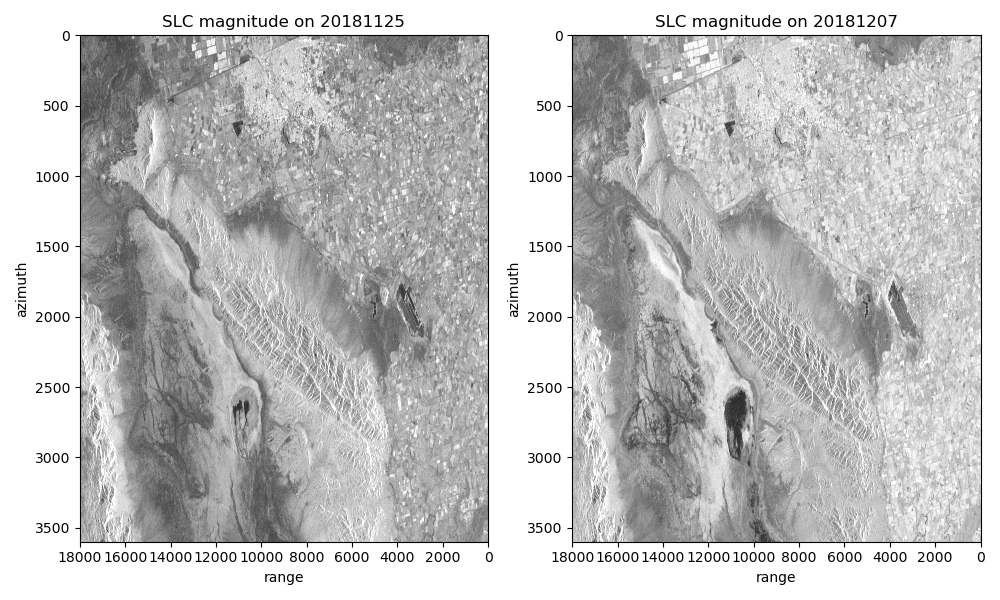

In [5]:
plt.figure(figsize=(10, 6),tight_layout=True)

my_vmin = 1
my_vmax = 2.2

plt.subplot(1,2,1)
plt.imshow(np.log10(slc1mag), vmin=my_vmin, vmax=my_vmax, cmap='gray', aspect='auto')
plt.xlim(np.shape(slc1mag)[1], 0)
plt.xlabel('range')
plt.ylabel('azimuth')
plt.title('SLC magnitude on '+str(date1))

plt.subplot(1,2,2)
plt.imshow(np.log10(slc2mag), vmin=my_vmin, vmax=my_vmax, cmap='gray', aspect='auto')
plt.xlim(np.shape(slc2mag)[1], 0)
plt.xlabel('range')
plt.ylabel('azimuth')
plt.title('SLC magnitude on '+str(date2))

plt.show()

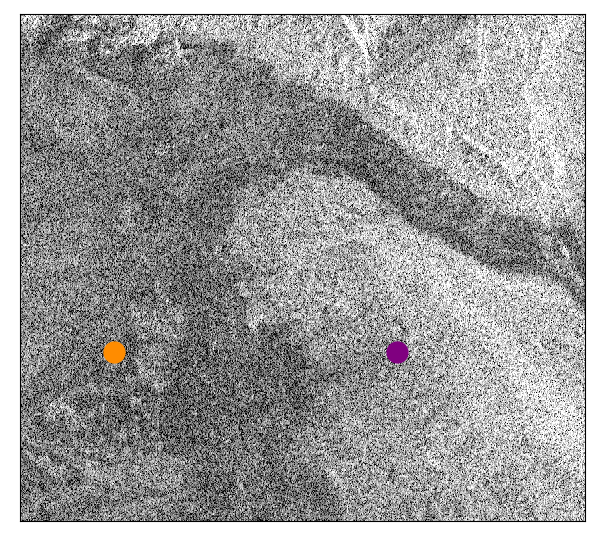

In [6]:
# This one is for my poster 10-30-22
# just plotting mag for small region of full res unwrapping
#plt.figure(figsize=(72/12,65/12),tight_layout=True)
plt.figure(figsize=(6,5.5),tight_layout=True)
im = plt.imshow(np.log10(slc1mag), aspect='auto', cmap='gray', \
                vmin=my_vmin, vmax=my_vmax, interpolation='nearest')
#plt.imshow(np.log10(slc1mag), vmin=my_vmin, vmax=my_vmax, cmap='gray', aspect='auto')
plt.xlim([17000,14000]); plt.ylim([1750,1000])
#plt.xlabel('range')
#plt.ylabel('azimuth')
plt.xticks([]); plt.yticks([])
plt.plot(15000,1500,'o',color='purple',markersize=15)
plt.plot(16500,1500,'o',color='darkorange',markersize=15)
#plt.title('SLC magnitude on '+str(date1))
plt.show()

#plt.savefig("full_res_area.png", transparent=True)

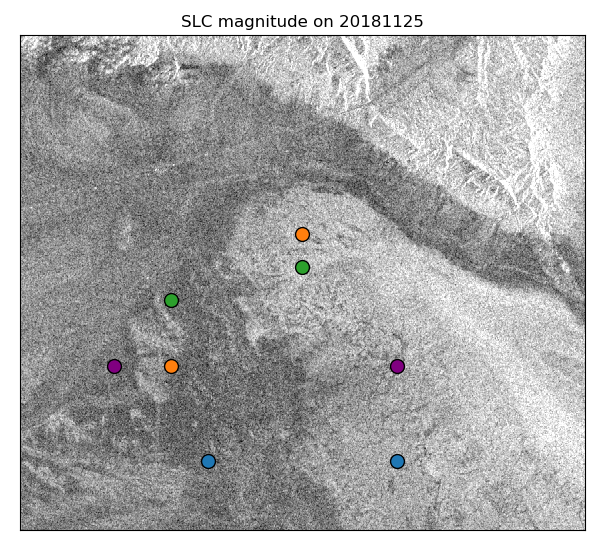

In [8]:
# This one is for my poster 12-05-22 (AGU)
my_vmin = 1
my_vmax = 2.2
# filter it slightly for better display, actual magnitudes don't really matter for this.
slc_filt=gaussian_filter(slc1mag, sigma=[alooks/10,rlooks/10])
slc_filt_cropped = slc_filt[1000:1750,14000:17000]

# just plotting mag for small region of full res unwrapping
plt.figure(figsize=(6,5.5),tight_layout=True)

im = plt.imshow(np.log10(slc_filt_cropped), aspect='auto', cmap='gray', \
                vmin=my_vmin, vmax=my_vmax, interpolation='nearest')
plt.xlim([3000,0]); 
#plt.xlabel('range')
#plt.ylabel('azimuth')
plt.xticks([]); plt.yticks([])
# plot points a,b,c,d,e,f,g,h
size = 10
plt.plot(2500,500,'o',color='purple',markersize=size,mec='k') # a
plt.plot(1000,500,'o',color='purple',markersize=size,mec='k') # b
plt.plot(2200,500,'o',color='tab:orange',markersize=size,mec='k') # c
plt.plot(1500,300,'o',color='tab:orange',markersize=size,mec='k') # d
plt.plot(2200,400,'o',color='tab:green',markersize=size,mec='k') # e
plt.plot(1500,350,'o',color='tab:green',markersize=size,mec='k') # f
plt.plot(2000,645,'o',color='tab:blue',markersize=size,mec='k') # g
plt.plot(1000,645,'o',color='tab:blue',markersize=size,mec='k') # h
plt.title('SLC magnitude on '+str(date1))
plt.show()

#plt.savefig("slc_a-h_points_labelled.png", transparent=True)

Calculate the interferogram (full resolution).


In [7]:
int12 = slc1 * np.conj(slc2)

Plot the interferogram.

In [ ]:
plt.figure(figsize=(10, 12),tight_layout=True)
plt.imshow(np.angle(int12),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='auto', interpolation='nearest')
plt.xlim(np.shape(int12)[1], 0)
plt.title('full res igram '+str(date1)+'-'+str(date2))
plt.xlabel('range')
plt.ylabel('azimuth')
plt.show()

If you'd like to plot igrams with both VV and VH, see the following notebook: 
>/data/ocp4/LagunaSalada/10_vv_vh/plot_igram_with_vv_vh.ipynb

Filter the igram and calculate coherence the classic way. <br> 
This filters the full resolution igram and divides it by the filtered SLCs. 

In [ ]:
s1=slc1*np.conj(slc1)
s2=slc2*np.conj(slc2)

a1r=gaussian_filter(np.real(s1), sigma=[alooks/4,rlooks/4])
a1i=gaussian_filter(np.imag(s1), sigma=[alooks/4,rlooks/4])
a2r=gaussian_filter(np.real(s2), sigma=[alooks/4,rlooks/4])
a2i=gaussian_filter(np.imag(s2), sigma=[alooks/4,rlooks/4])
a1 = a1r+1j*a1i
a2 = a2r+1j*a2i

filtimager=gaussian_filter(np.real(int12), sigma=[alooks/4,rlooks/4])
filtimagei=gaussian_filter(np.imag(int12), sigma=[alooks/4,rlooks/4])

filtimage = filtimager+1j*filtimagei
scaler    = np.sqrt(a1*a2)
filtimage = filtimage/scaler

Plot filtered igram next to full res igram.

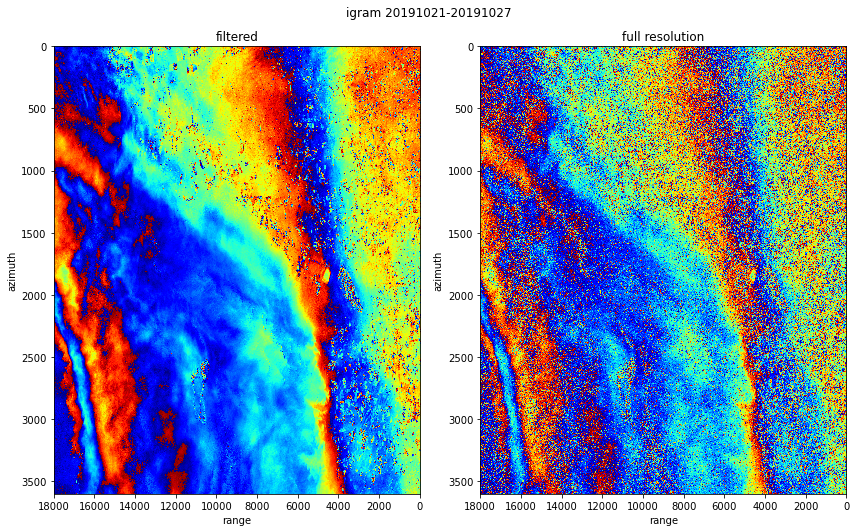

In [ ]:
plt.figure(figsize=(12,7.5),tight_layout=True)

plt.subplot(1,2,1)
plt.imshow(np.angle(filtimage),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='auto',interpolation='nearest')
plt.xlim([np.shape(filtimage)[1],0])
plt.title('filtered')
plt.xlabel('range')
plt.ylabel('azimuth')

plt.subplot(1,2,2)
plt.imshow(np.angle(int12),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='auto', interpolation='nearest')
plt.xlim(np.shape(int12)[1], 0)
plt.title('full resolution')
plt.xlabel('range')
plt.ylabel('azimuth')

plt.suptitle('igram '+str(date1)+'-'+str(date2))

plt.show()

Plot the spatial coherence.

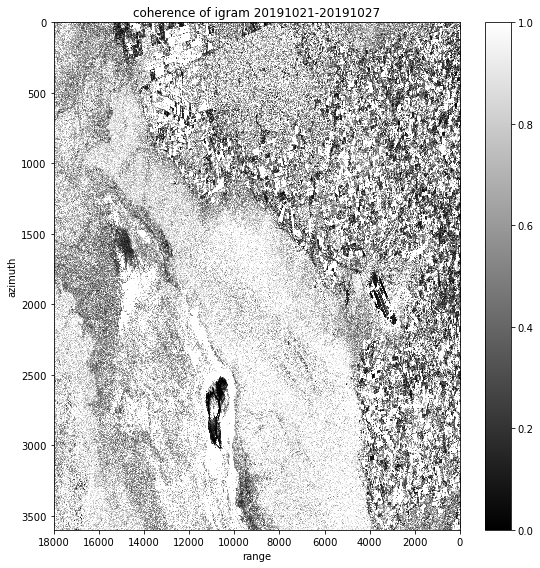

In [ ]:
plt.figure(figsize=(8, 8),tight_layout=True)
plt.imshow(np.abs(filtimage),vmin = 0,vmax=1 ,cmap='gray', aspect='auto', interpolation='nearest')
plt.xlim([np.shape(filtimage)[1],0])
plt.title('coherence of igram '+str(date1)+'-'+str(date2))
plt.xlabel('range')
plt.ylabel('azimuth')
plt.colorbar()
plt.show()